**TODO**
- MNB : rebalance classes and recheck scores for each class
- LSTM
- BERT
- SLM

Checking we are using rugal-notebooks-env conda environment

In [20]:
!which python

/Users/a.villa.massone/miniconda3/envs/frugal-notebooks-env/bin/python


Checking the python version is 3.9 (compatibility with frugal AI codebase)

In [21]:
!python --version

Python 3.9.21


To clear the cache, uncomment

In [22]:
# from huggingface_hub.utils import hf_hub_download
# hf_hub_download.clear_cache()

# Text classification exploration

## Let's explore the dataset

**Loading the dataset**

In [23]:
import pandas as pd

df = pd.read_parquet("hf://datasets/QuotaClimat/frugalaichallenge-text-train/train.parquet")

In [24]:
df.head()

,quote,label,source,url,language,subsource,id
0,"There is clear, compelling evidence that many ...",5_science_unreliable,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,CARDS,None
1,"For most of the Holocene (last 10k years), sea...",1_not_happening,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,hamburg_test1,None
2,"China, which hosts U.N. climate talks next wee...",4_solutions_harmful_unnecessary,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,CARDS,None
3,And the fabricated documents (which Dr. Mann a...,0_not_relevant,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,CARDS,None
4,It's going to be 42 here today and the hottest...,1_not_happening,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,hamburg_test3,None


**We will only use the quote and label columns**

In [25]:
df.columns

Index(['quote', 'label', 'source', 'url', 'language', 'subsource', 'id'], dtype='object')

**The label have 8 classes**

In [26]:
print('unique values:')
print('label\n', df['label'].unique())
print('source\n', df['source'].unique())
print('language\n', df['language'].unique())
print('subsource\n', df['subsource'].unique())
print('id\n', df['id'].unique())

unique values:
label
 ['5_science_unreliable' '1_not_happening'
 '4_solutions_harmful_unnecessary' '0_not_relevant' '6_proponents_biased'
 '7_fossil_fuels_needed' '2_not_human' '3_not_bad']
source
 ['FLICC' 'Desmog']
language
 ['en']
subsource
 ['CARDS' 'hamburg_test1' 'hamburg_test3' 'jindev' 'jintrain'
 'hamburg_test2' 'Alhindi_train' 'jintest' 'Alhindi_dev' 'Alhindi_test'
 None]
id
 [None]


**No duplicate quotes**

In [27]:
df['quote'].duplicated().sum()

0

**But we have a bit of unbalanced classes (that we will have to take care of)**

In [28]:
class_distribution = df['label'].value_counts().sort_index()
df['label'].value_counts(normalize=True).sort_index()

label
0_not_relevant                     0.265638
1_not_happening                    0.121655
2_not_human                        0.115252
3_not_bad                          0.063372
4_solutions_harmful_unnecessary    0.127073
5_science_unreliable               0.131505
6_proponents_biased                0.128386
7_fossil_fuels_needed              0.047119
Name: proportion, dtype: float64

In [29]:
import plotly.express as px

fig = px.bar(x=class_distribution.index, y=class_distribution.values, 
             labels={'x': 'Label', 'y': 'Count'})
fig.update_layout(width=900, height=400, title="Class Distribution")
fig.show(renderer='iframe')

**No missing values**

In [30]:
missing_values = df.isnull().sum()
print(missing_values)

quote           0
label           0
source          0
url             0
language        0
subsource    4295
id           6091
dtype: int64


**We will need to crop some quotes**

In [31]:
df['quote'][0], len(df['quote'][0])

('There is clear, compelling evidence that many of the major conclusions of the IPCC, your new religions constantly-changing Holy Book, are based on evidence that has been fabricated. The hockey stick graph that purported to abolish the mediaeval warm period is just one example.',
 277)

In [32]:
df['text_length'] = df['quote'].str.len()
print(df['text_length'].describe())

count    6091.000000
mean      293.528485
std       258.330755
min        19.000000
25%       139.000000
50%       228.000000
75%       365.000000
max      4703.000000
Name: text_length, dtype: float64


In [33]:
import numpy as np
threshold = np.percentile(df['text_length'], 90)
threshold

544.0

In [34]:
fig = px.histogram(df, x='text_length', nbins=50)
fig.update_layout(width=800, height=400, title="Sentence Length Distribution")
fig.show(renderer='iframe')

## Let's prepare the data for a MultinomialNB model

**What will need to be done:**
- pre-cleaning : strip, split, lowercase, numbers, punctuation/symbols, special chars, URLs
- tokenizing | NLTK.tokenize
- stopwords : irrelevant frequent words | nltk.corpus stopwords
- lemmatizing/stemming : roots | nltk.stem - WordNetLemmatizer
- vectorizing
    - Bag-of-words (CountVectorizer) counting : word order, doc len, doc context not taken into account
    - Tf-idf (TdidfVectorizer) weighting : word order, doc context not taken into account
        - min_df (infrequent words)
        - max_df (frequent words)
        - max_features (curse of dimensionality)
        - ngram_range = (min_n, max_n) (capturing the context of the words)

**Let's define our features and target**

In [35]:
X = df['quote']
y = df['label']
X.shape, y.shape

((6091,), (6091,))

In [74]:
def print_head(df):
    for i in range(5):
        print(i, df[i], '\n')
    print('shape:',df.shape)

In [37]:
print_head(X)

0 There is clear, compelling evidence that many of the major conclusions of the IPCC, your new religions constantly-changing Holy Book, are based on evidence that has been fabricated. The hockey stick graph that purported to abolish the mediaeval warm period is just one example. 

1 For most of the Holocene (last 10k years), sea level has been rising at a rate of around 2mm per year. Climate change has little to do with it - it's simply a long term inevitability which will end when the current interglacial returns to a glacial period (which we will regret). 

2 China, which hosts U.N. climate talks next week for the first time, is promoting what it calls ambitious plans to boost energy efficiency and curb emissions. But its supercharged growth means even with rapid efficiency gains it cancels out other global efforts to combat climate change. 

3 And the fabricated documents (which Dr. Mann apparently still thinks is factual) which lead to the sort of misinformation Dr. Mann uses, are 

**Cleaning**

In [38]:
import string
import re

def basic_cleaning(sentence):
    sentence = sentence.lower()
    sentence = ''.join(char for char in sentence if not char.isdigit())

    for punctuation in string.punctuation:
        sentence = sentence.replace(punctuation, '')
    sentence = sentence.strip()
    return sentence

In [39]:
X_clean = X.apply(basic_cleaning)
print_head(X_clean)

0 there is clear compelling evidence that many of the major conclusions of the ipcc your new religions constantlychanging holy book are based on evidence that has been fabricated the hockey stick graph that purported to abolish the mediaeval warm period is just one example 

1 for most of the holocene last k years sea level has been rising at a rate of around mm per year climate change has little to do with it  its simply a long term inevitability which will end when the current interglacial returns to a glacial period which we will regret 

2 china which hosts un climate talks next week for the first time is promoting what it calls ambitious plans to boost energy efficiency and curb emissions but its supercharged growth means even with rapid efficiency gains it cancels out other global efforts to combat climate change 

3 and the fabricated documents which dr mann apparently still thinks is factual which lead to the sort of misinformation dr mann uses are here 

4 its going to be  her

**Tokenizing**

In [40]:
import nltk
from nltk.tokenize import word_tokenize

In [49]:
nltk_path = "/Users/a.villa.massone/miniconda3/envs/frugal-notebooks-env/nltk_data"
nltk.download('punkt_tab', download_dir=nltk_path)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/a.villa.massone/miniconda3/envs/frugal-
[nltk_data]     notebooks-env/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [53]:
X_tokenized = X_clean.apply(word_tokenize)
print_head(X_tokenized)

0 ['there', 'is', 'clear', 'compelling', 'evidence', 'that', 'many', 'of', 'the', 'major', 'conclusions', 'of', 'the', 'ipcc', 'your', 'new', 'religions', 'constantlychanging', 'holy', 'book', 'are', 'based', 'on', 'evidence', 'that', 'has', 'been', 'fabricated', 'the', 'hockey', 'stick', 'graph', 'that', 'purported', 'to', 'abolish', 'the', 'mediaeval', 'warm', 'period', 'is', 'just', 'one', 'example'] 

1 ['for', 'most', 'of', 'the', 'holocene', 'last', 'k', 'years', 'sea', 'level', 'has', 'been', 'rising', 'at', 'a', 'rate', 'of', 'around', 'mm', 'per', 'year', 'climate', 'change', 'has', 'little', 'to', 'do', 'with', 'it', 'its', 'simply', 'a', 'long', 'term', 'inevitability', 'which', 'will', 'end', 'when', 'the', 'current', 'interglacial', 'returns', 'to', 'a', 'glacial', 'period', 'which', 'we', 'will', 'regret'] 

2 ['china', 'which', 'hosts', 'un', 'climate', 'talks', 'next', 'week', 'for', 'the', 'first', 'time', 'is', 'promoting', 'what', 'it', 'calls', 'ambitious', 'plans',

**Stopwords ??**

In [59]:
from nltk.corpus import stopwords

nltk.download('stopwords', download_dir=nltk_path)
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/a.villa.massone/miniconda3/envs/frugal-
[nltk_data]     notebooks-env/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [60]:
X_stopwords = X_tokenized.apply(lambda x: [w for w in x if w.lower() not in stop_words])

print_head(X_stopwords)

0 ['clear', 'compelling', 'evidence', 'many', 'major', 'conclusions', 'ipcc', 'new', 'religions', 'constantlychanging', 'holy', 'book', 'based', 'evidence', 'fabricated', 'hockey', 'stick', 'graph', 'purported', 'abolish', 'mediaeval', 'warm', 'period', 'one', 'example'] 

1 ['holocene', 'last', 'k', 'years', 'sea', 'level', 'rising', 'rate', 'around', 'mm', 'per', 'year', 'climate', 'change', 'little', 'simply', 'long', 'term', 'inevitability', 'end', 'current', 'interglacial', 'returns', 'glacial', 'period', 'regret'] 

2 ['china', 'hosts', 'un', 'climate', 'talks', 'next', 'week', 'first', 'time', 'promoting', 'calls', 'ambitious', 'plans', 'boost', 'energy', 'efficiency', 'curb', 'emissions', 'supercharged', 'growth', 'means', 'even', 'rapid', 'efficiency', 'gains', 'cancels', 'global', 'efforts', 'combat', 'climate', 'change'] 

3 ['fabricated', 'documents', 'dr', 'mann', 'apparently', 'still', 'thinks', 'factual', 'lead', 'sort', 'misinformation', 'dr', 'mann', 'uses'] 

4 ['goin

**Lemmatizing**

In [61]:
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet', download_dir=nltk_path)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/a.villa.massone/miniconda3/envs/frugal-
[nltk_data]     notebooks-env/nltk_data...


True

In [75]:
X_lemmatized = X_stopwords.apply(lambda x : [WordNetLemmatizer().lemmatize(w, pos = "v") for w in x])
print_head(X_lemmatized)

0 ['clear', 'compel', 'evidence', 'many', 'major', 'conclusions', 'ipcc', 'new', 'religions', 'constantlychanging', 'holy', 'book', 'base', 'evidence', 'fabricate', 'hockey', 'stick', 'graph', 'purport', 'abolish', 'mediaeval', 'warm', 'period', 'one', 'example'] 

1 ['holocene', 'last', 'k', 'years', 'sea', 'level', 'rise', 'rate', 'around', 'mm', 'per', 'year', 'climate', 'change', 'little', 'simply', 'long', 'term', 'inevitability', 'end', 'current', 'interglacial', 'return', 'glacial', 'period', 'regret'] 

2 ['china', 'host', 'un', 'climate', 'talk', 'next', 'week', 'first', 'time', 'promote', 'call', 'ambitious', 'plan', 'boost', 'energy', 'efficiency', 'curb', 'emissions', 'supercharge', 'growth', 'mean', 'even', 'rapid', 'efficiency', 'gain', 'cancel', 'global', 'efforts', 'combat', 'climate', 'change'] 

3 ['fabricate', 'document', 'dr', 'mann', 'apparently', 'still', 'think', 'factual', 'lead', 'sort', 'misinformation', 'dr', 'mann', 'use'] 

4 ['go', 'today', 'hottest', 'sum

**Vectorizing**

In [88]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
# vectorizer = TfidfVectorizer(ngram_range = (2,2))

X_lemmatized_text = X_lemmatized.apply(lambda words: " ".join(words))

X_vectorized = pd.DataFrame(
    vectorizer.fit_transform(X_lemmatized_text).toarray(),
    columns=vectorizer.get_feature_names_out(),
    index=X_lemmatized.index
)

vocabulary = vectorizer.get_feature_names_out()
print(f"Vocabulary size: {len(vocabulary)}")
print('shape:', X_vectorized.shape)
X_vectorized.head()

Vocabulary size: 13281
shape: (6091, 13281)


,aabe,ab,abandon,abandonment,abate,abatement,abbot,abbott,abc,abcs,...,ºc,äôm,äôs,äôt,üá,üáßwhy,üåª,üåç,üåû,üëç
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Let's have a look at the most frequent words**

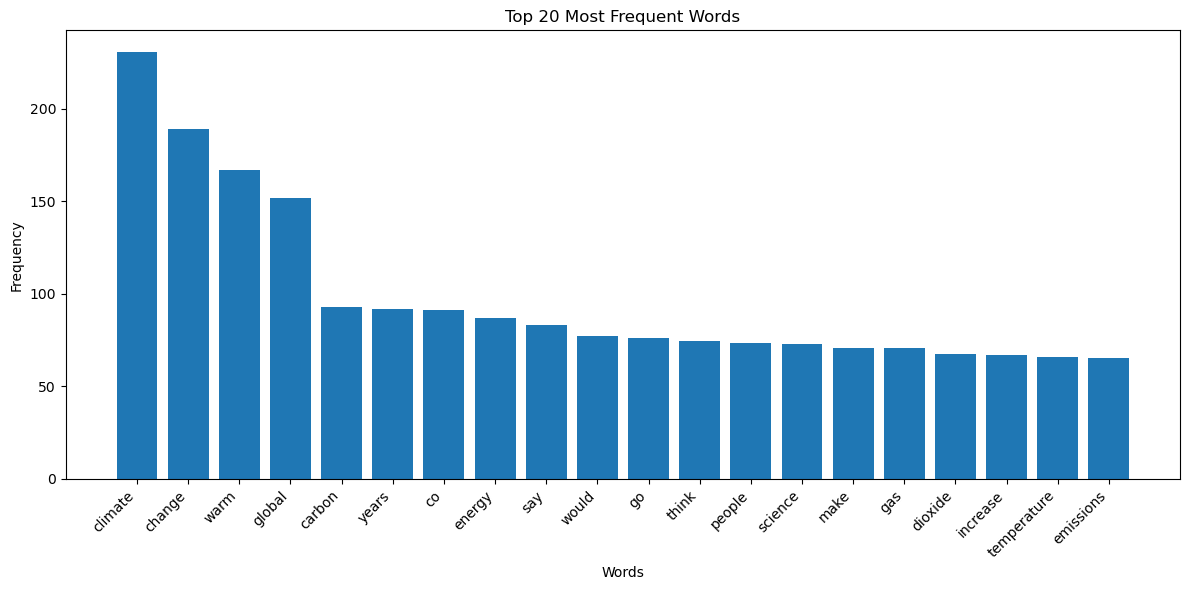


Total words: 25963.216238340217
Unique words: 13281
Average word frequency: 1.95


In [90]:
import matplotlib.pyplot as plt

word_freq = X_vectorized.sum(axis=0).values
word_freq_dict = dict(zip(vocabulary, word_freq))
sorted_word_freq = sorted(word_freq_dict.items(), key=lambda x: x[1], reverse=True)

top_20_words = sorted_word_freq[:20]
df_word_freq = pd.DataFrame(top_20_words, columns=['Word', 'Frequency'])

plt.figure(figsize=(12, 6))
plt.bar(df_word_freq['Word'], df_word_freq['Frequency'])
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

total_words = sum(word_freq)
unique_words = len(vocabulary)
average_freq = total_words / unique_words

print(f"\nTotal words: {total_words}")
print(f"Unique words: {unique_words}")
print(f"Average word frequency: {average_freq:.2f}")

**Now let's build our model**  
We check our feature and target

In [93]:
X_vectorized

,aabe,ab,abandon,abandonment,abate,abatement,abbot,abbott,abc,abcs,...,ºc,äôm,äôs,äôt,üá,üáßwhy,üåª,üåç,üåû,üëç
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6431,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6432,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6433,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
y

0                  5_science_unreliable
1                       1_not_happening
2       4_solutions_harmful_unnecessary
3                        0_not_relevant
4                       1_not_happening
                     ...               
6431                6_proponents_biased
6432                        2_not_human
6433                     0_not_relevant
6435               5_science_unreliable
6436                    1_not_happening
Name: label, Length: 6091, dtype: object

**Let's encode the target**

In [100]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_cat = le.fit_transform(y)
print(le.classes_)
y_cat

['0_not_relevant' '1_not_happening' '2_not_human' '3_not_bad'
 '4_solutions_harmful_unnecessary' '5_science_unreliable'
 '6_proponents_biased' '7_fossil_fuels_needed']


array([5, 1, 4, ..., 0, 5, 1])

In [105]:
X_vectorized.shape, y_cat.shape, type(X_vectorized), type(y_cat)

((6091, 13281), (6091,), pandas.core.frame.DataFrame, numpy.ndarray)

**Train test split**

In [151]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y_cat, test_size=0.2, stratify=y_cat, random_state=42)

print('types', type(X_train), type(X_test), type(y_train), type(y_test))
'Shapes', X_train.shape, X_test.shape, y_train.shape, y_test.shape

types <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


('Shapes', (4872, 13281), (1219, 13281), (4872,), (1219,))

**Model : MultinomialNB**

In [152]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB

multinomial_nb = MultinomialNB()

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

score = cross_val_score(multinomial_nb, X_train, y_train, cv=skf).mean()

print(f"Cross-validation accuracy on 10 folds: {round(score, 2)}")

Cross-validation accuracy on 10 folds: 0.46


In [153]:
multinomial_nb.fit(X_train, y_train)

MultinomialNB()

In [154]:
from sklearn.metrics import accuracy_score     # tp + tn / all  : maximize t
from sklearn.metrics import f1_score           # harmonic mean of the precision and recall
from sklearn.metrics import precision_score    # tp / (tp + fp) : minimize fp
from sklearn.metrics import recall_score       # tp / (tp + fn) : maximize tp


y_true = y_test
y_pred = multinomial_nb.predict(X_test)

scores = {}
scores['f1'] = f1_score(y_true, y_pred, average=None)
scores['precision'] = precision_score(y_true, y_pred, average=None)
scores['recall'] = recall_score(y_true, y_pred, average=None)

accuracy = accuracy_score(y_true, y_pred)

df_scores = pd.DataFrame(scores)
print('accuracy', accuracy)
df_scores

accuracy 0.4815422477440525


/Users/a.villa.massone/miniconda3/envs/frugal-notebooks-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



,f1,precision,recall
0,0.529825,0.370098,0.932099
1,0.658635,0.811881,0.554054
2,0.575758,0.617886,0.539007
3,0.166667,1.000000,0.090909
4,0.330097,0.666667,0.219355
5,0.530769,0.690000,0.431250
6,0.191011,0.809524,0.108280
7,0.000000,0.000000,0.000000


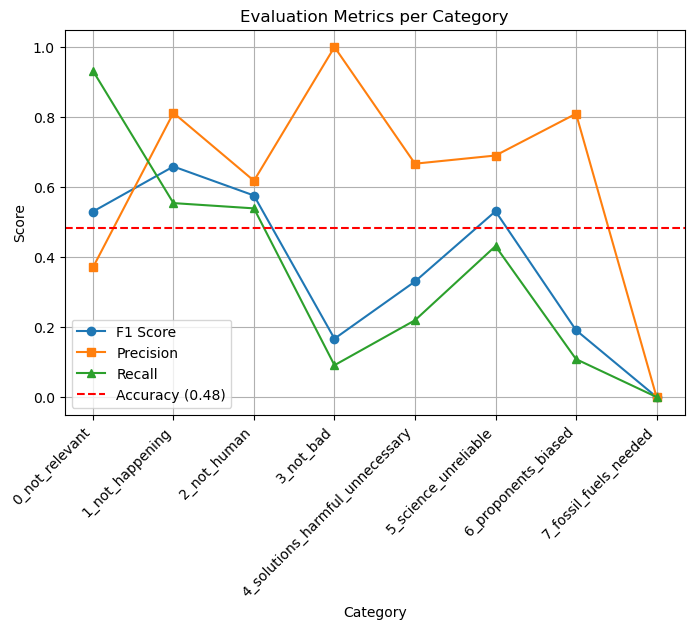

         f1  precision    recall
0  0.529825   0.370098  0.932099
1  0.658635   0.811881  0.554054
2  0.575758   0.617886  0.539007
3  0.166667   1.000000  0.090909
4  0.330097   0.666667  0.219355
5  0.530769   0.690000  0.431250
6  0.191011   0.809524  0.108280
7  0.000000   0.000000  0.000000


In [155]:
import numpy as np
import matplotlib.pyplot as plt

categories = np.arange(len(scores['f1']))

plt.figure(figsize=(8, 5))

plt.plot(categories, scores['f1'], marker='o', label='F1 Score')
plt.plot(categories, scores['precision'], marker='s', label='Precision')
plt.plot(categories, scores['recall'], marker='^', label='Recall')

plt.axhline(y=accuracy, color='r', linestyle='--', label=f'Accuracy ({accuracy:.2f})')

plt.xlabel("Category")
plt.ylabel("Score")
plt.title("Evaluation Metrics per Category")
plt.xticks(categories, le.classes_, rotation=45, ha="right")  # Align category names properly
plt.legend()
plt.grid(True)
plt.show()
print(df_scores)


## DL Baseline : LSTM

## LLM Baseline: test with Qwen/Qwen2.5-7B

In [158]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import os

In [159]:
model_name = "Qwen/Qwen2.5-0.5B"
# "Qwen/Qwen2.5-7B"
# "Qwen/Qwen2.5-0.5B"
# "Qwen/Qwen2.5-1.5B"

In [160]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [161]:
model = AutoModelForCausalLM.from_pretrained(model_name)

In [162]:
!du -sh ~/.cache/huggingface/hub/models--Qwen--Qwen2.5-0.5B

961M	/Users/a.villa.massone/.cache/huggingface/hub/models--Qwen--Qwen2.5-0.5B


In [163]:
def generate_response(prompt):
    inputs = tokenizer(prompt, return_tensors="pt")
    outputs = model.generate(**inputs, max_length=150)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response

In [164]:
prompt = """
Which category is this sentence ?
\n\n
Respond only with the index of the category
0_not_relevant
1_not_happening
2_not_human
3_not_bad
4_solutions_harmful_unnecessary
5_science_unreliable
6_proponents_biased
7_fossil_fuels_needed
\n\n
sentence :
For most of the Holocene (last 10k years), sea level has been rising at a rate of around 2mm per year. Climate change has little to do with it - it's simply a long term inevitability which will end when the current interglacial returns to a glacial period (which we will regret). 
"""

In [165]:
%%time
response = generate_response(prompt)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Both `max_new_tokens` (=2048) and `max_length`(=150) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


CPU times: user 1h 16min 35s, sys: 13min 49s, total: 1h 30min 25s
Wall time: 12min 18s


In [166]:
print(f"Prompt: {prompt}")
print(f"Response: {response}")

Prompt: 
Which category is this sentence ?



Respond only with the index of the category
0_not_relevant
1_not_happening
2_not_human
3_not_bad
4_solutions_harmful_unnecessary
5_science_unreliable
6_proponents_biased
7_fossil_fuels_needed



sentence :
For most of the Holocene (last 10k years), sea level has been rising at a rate of around 2mm per year. Climate change has little to do with it - it's simply a long term inevitability which will end when the current interglacial returns to a glacial period (which we will regret). 

Response: 
Which category is this sentence ?



Respond only with the index of the category
0_not_relevant
1_not_happening
2_not_human
3_not_bad
4_solutions_harmful_unnecessary
5_science_unreliable
6_proponents_biased
7_fossil_fuels_needed



sentence :
For most of the Holocene (last 10k years), sea level has been rising at a rate of around 2mm per year. Climate change has little to do with it - it's simply a long term inevitability which will end when the curre